In [ ]:
! pip install -q kaggle

!kaggle datasets download -d andrewmvd/animal-faces

! mkdir train

! unzip animal-faces.zip -d train

In [ ]:
import os
len(os.listdir('/content/train/afhq/train/wild'))

4738

In [ ]:
import numpy as np
import pandas as pd
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [ ]:
# Code to read images in matrix format

def showimage(img_path):
  img = mpimg.imread(img_path)
  return img

In [ ]:
img = showimage('/content/train/afhq/train/wild/flickr_wild_000005.jpg')
img.shape

(512, 512, 3)

In [ ]:
# Code to create batches of data

def make_dataset(batch_size):
  numsets = len(os.listdir('/content/train/afhq/train/wild'))//batch_size
  data = []
  for i in range(numsets):
    batch = []
    for j in range(i*batch_size, (i+1)*batch_size):
      choice = os.listdir('/content/train/afhq/train/wild')[j]
      img = showimage(f'/content/train/afhq/train/wild/{choice}')
      img = resize(img, (64, 64))
      img = img.astype('float32')
      batch.append(img)
    data.append(np.array(batch))
  return data

In [ ]:
trydata = make_dataset(1)
trydata[1]

array([[[[0.6901961 , 0.62352943, 0.54509807],
         [0.6901961 , 0.62352943, 0.54509807],
         [0.6901961 , 0.62352943, 0.54509807],
         ...,
         [0.67058825, 0.6       , 0.52156866],
         [0.6627451 , 0.59607846, 0.5264706 ],
         [0.65882355, 0.5921569 , 0.5254902 ]],

        [[0.6901961 , 0.62352943, 0.54509807],
         [0.6862745 , 0.61960787, 0.5411765 ],
         [0.6862745 , 0.61960787, 0.5411765 ],
         ...,
         [0.6696078 , 0.6       , 0.51862746],
         [0.6666667 , 0.6       , 0.51666665],
         [0.6666667 , 0.6019608 , 0.5176471 ]],

        [[0.6901961 , 0.62352943, 0.54509807],
         [0.6882353 , 0.6215686 , 0.54313725],
         [0.6862745 , 0.61960787, 0.5411765 ],
         ...,
         [0.67058825, 0.6       , 0.5137255 ],
         [0.6666667 , 0.6       , 0.50980395],
         [0.6666667 , 0.6       , 0.50784314]],

        ...,

        [[0.15686275, 0.14117648, 0.12058824],
         [0.17941177, 0.15196079, 0.12352941]

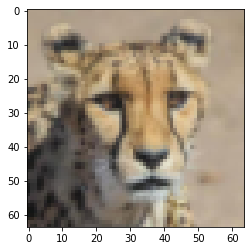

In [ ]:
plt.imshow(trydata[1][0])

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, Dense, Conv2DTranspose, Reshape, LeakyReLU, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Code to create the discriminator model for differentiating between real and fake images

def discriminator():
  def block(x, filters):
    x = Conv2D(filters=filters, kernel_size=(5,5), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    return x
  
  input = Input(shape = (64,64,3))
  x = block(input, 32)
  x = block(x, 64)
  x = block(x, 128)
  x = block(x, 256)
  x = Flatten()(x)
  final = Dense(1, activation='sigmoid')(x)

  model = Model(inputs = input , outputs = final)

  return model

In [ ]:
dis_model = discriminator()
dis_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0     

In [ ]:
# Code to create the generator model for for creating fake images

def generator():
  def block(x, filters, strides = 4):
    x = Conv2DTranspose(filters=filters, kernel_size=(5,5), strides=(strides,strides), padding='same', activation = 'selu')(x)
    x = BatchNormalization()(x)
    return x

  input = Input(shape = (50, ))
  x = Dense(8*8*64)(input)
  x = Reshape((8, 8, 64))(x)
  x = block(x, 32)
  final = Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', activation = 'tanh')(x)

  model = Model(inputs = input , outputs = final)

  return model

In [ ]:
gen_model = generator()
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 32)        51232     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 3)         2403      
Total params: 262,659
Trainable params: 262,595
Non-trainable params: 64
____________________________________________________

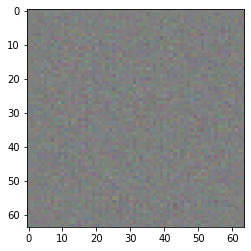

In [ ]:
# Here we can see that the generator model generates just noise initially without any training

noise = tf.random.normal(shape = [1, 50])
plt.imshow((gen_model(noise)[0]+1)/2)

In [ ]:
# Here we can see that the discriminator model cannot distinguish between real and fake images without any training

dis_model(gen_model(noise))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50001556]], dtype=float32)>

In [ ]:
# Here we assemble the discriminator and generator models to create the GAN model consisting of both

input = Input(shape = (50, ))

dis_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
dis_model.trainable = False

x = gen_model(input)
final = dis_model(x)

gan_model = Model(inputs = input, outputs = final)

gan_model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 3)         262659    
_________________________________________________________________
model (Functional)           (None, 1)                 1082177   
Total params: 1,344,836
Trainable params: 262,595
Non-trainable params: 1,082,241
_________________________________________________________________


In [ ]:
gan_model.layers

In [ ]:
from numpy import vstack

In [ ]:
batch_size = 64
data = make_dataset(batch_size)

In [ ]:
total_steps = 500
epochs = 1
improvement = []

In [ ]:
# Training the GAN model

for step in range(total_steps):
  i = 1
  for realX in data:
    realY = np.ones((batch_size, 1))            # Correct y value for real images

    noise = tf.random.normal(shape = [batch_size, 50])
    fakeX = gen_model(noise)                    # Generating fake images  
    fakeY = np.zeros((batch_size, 1))           # Correct y value for fake images

    x, y = vstack((realX, fakeX)), vstack((realY, fakeY))

    gan_model.layers[2].trainable = True
    gan_model.layers[2].train_on_batch(x, y)    # Training just the discriminator model

    gan_model.layers[2].trainable = False
  
    for _ in range(epochs):
      gan_model.train_on_batch(noise, realY)    # Training the whole GAN model after making dicriminator model untrainable => only the generator model will train

    print(f'Set {i} done')
    i += 1
  
  if ((step+1)%50 == 0):                        # Saving every 50th image
    improvement.append(gan_model.layers[1](noise)[0])

  print(step+1, ' step done')

In [ ]:
len(improvement)

10

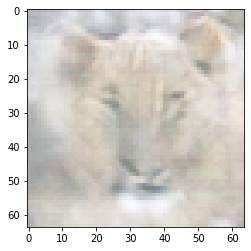

In [ ]:
plt.imshow((improvement[-1]+1)/2)

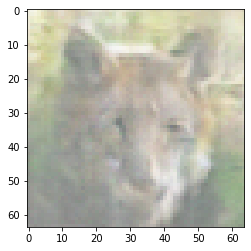

In [ ]:
plt.imshow((gan_model.layers[1](tf.random.normal(shape = [1, 50]))[-1]+1)/2)

In [ ]:
gan_model.save("/GAN/GAN_model.h5")

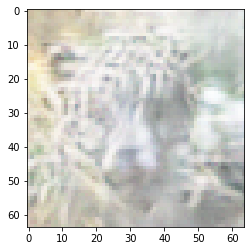

In [ ]:
#Code to generate fake image from saved model

from keras.models import load_model
 
# load model
model = load_model('/GAN/GAN_model.h5')

import matplotlib.pyplot as plt
import tensorflow as tf

plt.imshow((model.layers[1](tf.random.normal(shape = [1, 50]))[-1]+1)/2)